<a href="https://colab.research.google.com/github/silviolima07/FIESC/blob/main/FIESC_CD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

In [2]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print ("Seu dataframe tem " + str(df.shape[1]) + " colunas.\n"      
            "Há " + str(mis_val_table_ren_columns.shape[0]) +
              " colunas que possuem valores ausentes.")
        
        return mis_val_table_ren_columns

Utilize o Google Colab com PySpark (ou Pandas) para realizar uma análise exploratória dos
dados de prova do Enem 2019, com o intuito de responder os seguintes questionamentos:
1. Quais as matrizes e habilidades mais cobradas na edição?
2. Quais as matrizes e habilidades menos cobradas na edição?
3. Existe desproporcionalidade (quantidade) entre as matrizes e habilidades cobradas na
edição?
4. Você encontrou mais alguma informação relevante sobre a análise? Se sim, qual(ais)?

## Instalação do pyspark no colab

In [3]:
# instalar as dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [4]:
# configurar as variáveis de ambiente
import os
# Definindo a variável de ambiente do Java
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# Definindo a variável de ambiente do Spark
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [5]:
# Importando a findspark
import findspark

# Iniciando o findspark
findspark.init()

In [6]:
from pyspark.sql.types import IntegerType

In [7]:
# iniciar uma sessão local e importar dados do Airbnb
from pyspark.sql import SparkSession
sc = SparkSession.builder.master('local[*]').getOrCreate()

# carregar dataset
df_spark = sc.read.csv("/content/drive/MyDrive/DATASETS/Itens_Prova_Enem_2019.csv", sep=';', header='true')


# ver algumas informações sobre os tipos de dados de cada coluna
df_spark.printSchema()

root
 |-- CO_POSICAO: string (nullable = true)
 |-- SG_AREA: string (nullable = true)
 |-- CO_ITEM: string (nullable = true)
 |-- TX_GABARITO: string (nullable = true)
 |-- CO_HABILIDADE: string (nullable = true)
 |-- TX_COR: string (nullable = true)
 |-- CO_PROVA: string (nullable = true)
 |-- TP_LINGUA: string (nullable = true)
 |-- IN_ITEM_ADAPTADO: string (nullable = true)



In [8]:
df_spark.show(5)

+----------+-------+-------+-----------+-------------+------+--------+---------+----------------+
|CO_POSICAO|SG_AREA|CO_ITEM|TX_GABARITO|CO_HABILIDADE|TX_COR|CO_PROVA|TP_LINGUA|IN_ITEM_ADAPTADO|
+----------+-------+-------+-----------+-------------+------+--------+---------+----------------+
|         1|     LC|  55166|          B|            7|  Azul|     511|        0|               0|
|         2|     LC|  54110|          D|            7|  Azul|     511|        0|               0|
|         3|     LC|  23564|          A|            6|  Azul|     511|        0|               0|
|         4|     LC|  31954|          B|            8|  Azul|     511|        0|               0|
|         5|     LC| 118180|          E|            5|  Azul|     511|        0|               0|
+----------+-------+-------+-----------+-------------+------+--------+---------+----------------+
only showing top 5 rows



# Coluna 'count' representa a contagem de questões em cada area do conhecimento (SG_AREA)

In [9]:
df_spark.groupBy('SG_AREA').count().orderBy('count').show()

+-------+-----+
|SG_AREA|count|
+-------+-----+
|     CN|  450|
|     MT|  450|
|     CH|  495|
|     LC|  550|
+-------+-----+



# Coluna CO_HABILIDADE possue 30 valores representando o codigo de cada habilidade.
# Coluna 'count' representa a contagem de cada habilidade em cada area do conhecimento (SG_AREA)


# *1) Quais as matrizes e habilidades mais cobradas na edição?*
# Top 10 

In [10]:
df_spark.groupBy('SG_AREA','CO_HABILIDADE').count().orderBy('count', ascending=False).show(10)

+-------+-------------+-----+
|SG_AREA|CO_HABILIDADE|count|
+-------+-------------+-----+
|     LC|           16|   44|
|     CH|           11|   33|
|     CH|           15|   33|
|     CH|           23|   33|
|     LC|            6|   32|
|     LC|            7|   28|
|     LC|            8|   28|
|     LC|           17|   27|
|     MT|           21|   26|
|     CN|           20|   24|
+-------+-------------+-----+
only showing top 10 rows



# *2) Quais as matrizes e habilidades menos cobradas na edição?*
# Down 10


In [11]:
df_spark.groupBy('SG_AREA','CO_HABILIDADE').count().orderBy('count', ascending=True).show(10)

+-------+-------------+-----+
|SG_AREA|CO_HABILIDADE|count|
+-------+-------------+-----+
|     MT|           22|    4|
|     CH|           13|    5|
|     CH|           10|    6|
|     LC|           13|    6|
|     CH|           25|    6|
|     LC|           29|    6|
|     MT|            6|    9|
|     MT|           10|   10|
|     CN|           13|   10|
|     CN|           11|   10|
+-------+-------------+-----+
only showing top 10 rows



# 3) Existe desproporcionalidade (quantidade) entre as matrizes e habilidades cobradas na edição?

## Filtrar por AREA e agrupar para identificar a quantidade de cada habilidade

## Criar um dataframe para cada area

In [12]:
df_MT = df_spark.filter(df_spark.SG_AREA=='MT')
df_MT2 = df_MT.groupBy('CO_HABILIDADE').count().orderBy('count')
df_MT2 = df_MT2.withColumnRenamed('count', 'MT')
df_MT2 = df_MT2.toPandas()
#
df_CN = df_spark.filter(df_spark.SG_AREA=='CN')
df_CN2 = df_CN.groupBy('CO_HABILIDADE').count().orderBy('count')
df_CN2 = df_CN2.withColumnRenamed('count', 'CN')
df_CN2 = df_CN2.toPandas()
#
df_CH = df_spark.filter(df_spark.SG_AREA=='CH')
df_CH2 = df_CH.groupBy('CO_HABILIDADE').count().orderBy('count')
df_CH2 = df_CH2.withColumnRenamed('count', 'CH')
df_CH2 = df_CH2.toPandas()
#
df_LC = df_spark.filter(df_spark.SG_AREA=='LC')
df_LC2 = df_LC.groupBy('CO_HABILIDADE').count().orderBy('count')
df_LC2 = df_LC2.withColumnRenamed('count', 'LC')
df_LC2 = df_LC2.toPandas()

In [13]:
df_MT2.head()

,CO_HABILIDADE,MT
0,22,4
1,6,9
2,7,10
3,15,10
4,11,10


In [14]:
print('Areas:\n','MT=',df_MT2.shape,'\n CN=', df_CN2.shape, '\n CH=', df_CH2.shape,'\n LC=', df_LC2.shape )

Areas:
 MT= (30, 2) 
 CN= (30, 2) 
 CH= (30, 2) 
 LC= (30, 2)


In [15]:
data_frames = [df_MT2, df_CN2, df_CH2, df_LC2]

In [16]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['CO_HABILIDADE'],
                                            how='outer'), data_frames)

In [17]:
df_merged['CO_HABILIDADE']= df_merged['CO_HABILIDADE'].astype('int32')

# Em cada AREA quantas vezes uma HABILIDADE está presente.

In [18]:
df_merged.sort_values(by=['CO_HABILIDADE'])

,CO_HABILIDADE,MT,CN,CH,LC
28,1,21,16,22,17
16,2,16,20,21,11
17,3,20,20,17,16
25,4,20,10,16,21
7,5,10,10,22,22
1,6,9,16,17,32
2,7,10,20,22,28
18,8,20,20,21,28
23,9,20,16,11,11
11,10,10,10,6,17


# Remodelagem do dataset.
# Criar uma coluna com as matrizes.

In [19]:
df = pd.melt(df_merged, id_vars="CO_HABILIDADE", var_name="MATRIZ", value_name="count")
df


,CO_HABILIDADE,MATRIZ,count
0,22,MT,4
1,6,MT,9
2,7,MT,10
3,15,MT,10
4,11,MT,10
...,...,...,...
115,4,LC,21
116,12,LC,16
117,14,LC,17
118,1,LC,17


# O gráfico mostra que algumas matrizes apresentam quantidades maiores de habilidades no Enem.

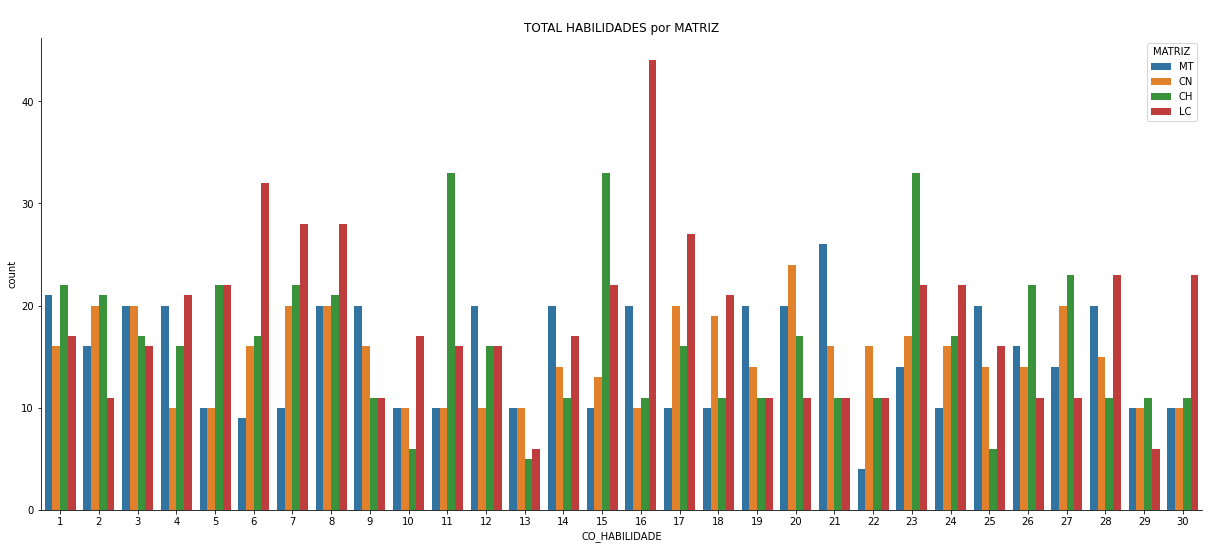

In [20]:
ax = sns.catplot(x='CO_HABILIDADE', y= 'count', hue='MATRIZ', data=df, kind='bar', height=5, aspect=3,legend_out=False)
#sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, .9), ncol=4, title=None, frameon=True)
ax.fig.set_figwidth(17)
ax.fig.set_figheight(7.7)
# Show the plot
plt.title('\nTOTAL HABILIDADES por MATRIZ')
plt.show()

In [21]:
df_spark.filter((df_spark.SG_AREA=='LC') & (df_spark.CO_HABILIDADE=='16')).show(100)


+----------+-------+-------+-----------+-------------+-------+--------+---------+----------------+
|CO_POSICAO|SG_AREA|CO_ITEM|TX_GABARITO|CO_HABILIDADE| TX_COR|CO_PROVA|TP_LINGUA|IN_ITEM_ADAPTADO|
+----------+-------+-------+-----------+-------------+-------+--------+---------+----------------+
|        14|     LC| 118232|          E|           16|   Azul|     511|     null|               0|
|        22|     LC| 118306|          A|           16|   Azul|     511|     null|               0|
|        28|     LC| 118278|          B|           16|   Azul|     511|     null|               0|
|        41|     LC| 118276|          C|           16|   Azul|     511|     null|               0|
|        10|     LC| 118306|          A|           16|Amarela|     512|     null|               0|
|        14|     LC| 118278|          B|           16|Amarela|     512|     null|               0|
|        25|     LC| 118276|          C|           16|Amarela|     512|     null|               0|
|        4

# Apresentar em cada AREA, quantidade de cada HABILIDADE presente.



								MATRIZES e HABILIDADES
								Ordenado pela Habilidade



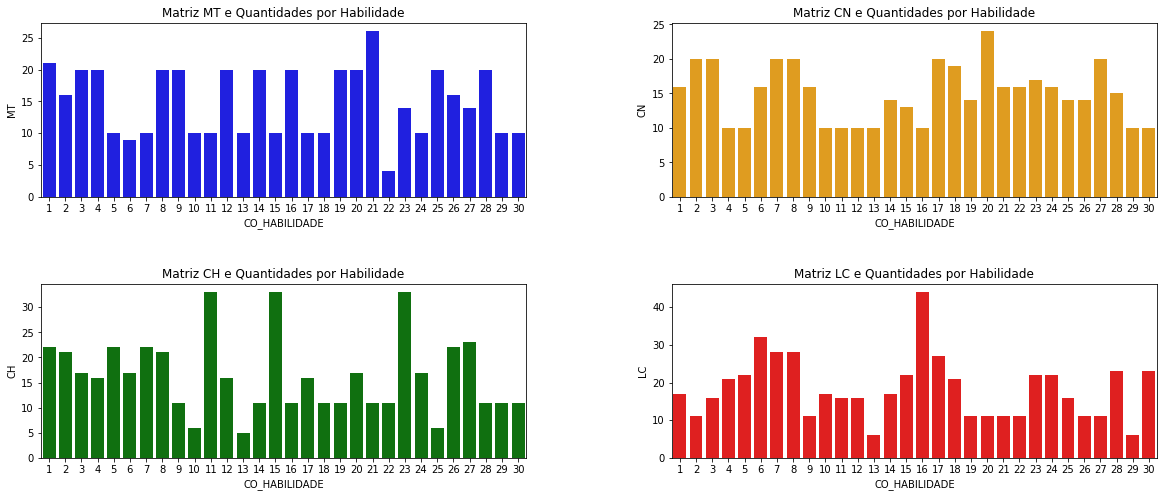

In [22]:
#definindo o tamanho das figuras
fig = plt.figure(figsize=(20, 8))
print("\t\t\t\t\t\t\t\tMATRIZES e HABILIDADES\n\t\t\t\t\t\t\t\tOrdenado pela Habilidade\n")
#espaço entre os gráficos
plt.subplots_adjust(wspace=0.3,hspace=0.5)
# Gráfico 1 - AREA MT
ax1=fig.add_subplot(221)
sns.barplot(x='CO_HABILIDADE',   y='MT', data=df_merged, color='blue')
plt.title("Matriz MT e Quantidades por Habilidade")
# Gráfico 2 - AREA CN
ax2=fig.add_subplot(222)
sns.barplot(x='CO_HABILIDADE',   y='CN', data=df_merged, color='orange')
plt.title("Matriz CN e Quantidades por Habilidade")
# Gráfico 3 - AREA CH
ax3=fig.add_subplot(223)
sns.barplot(x='CO_HABILIDADE',   y='CH', data=df_merged, color='green')
plt.title("Matriz CH e Quantidades por Habilidade")
# Gráfico 4 - AREA LC
ax4=fig.add_subplot(224)
sns.barplot(x='CO_HABILIDADE',   y='LC', data=df_merged, color='red')
plt.title("Matriz LC e Quantidades por Habilidade");

								MATRIZES e HABILIDADES
							Ordenado pelo contagem total da habilidade



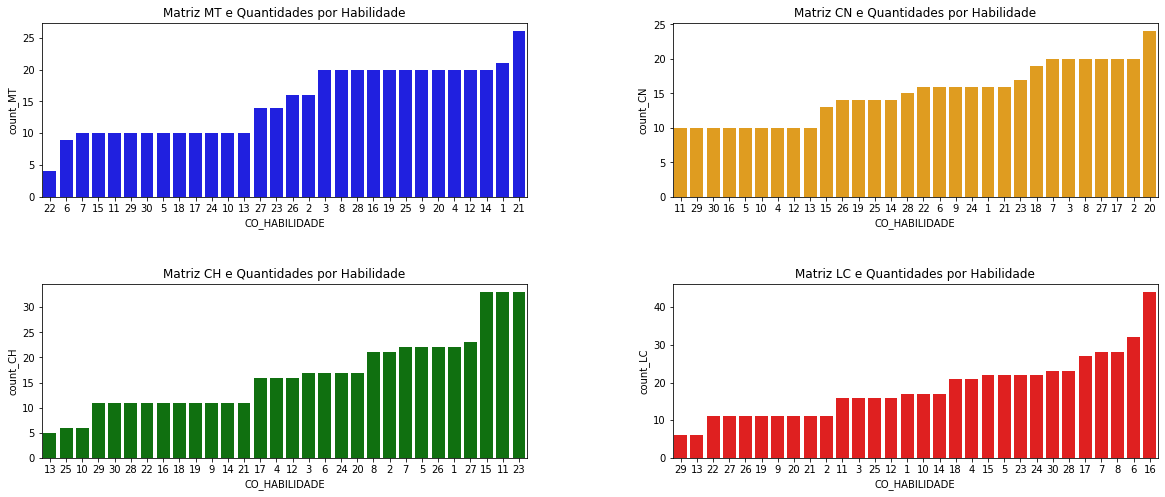

In [23]:
#definindo o tamanho das figuras
fig = plt.figure(figsize=(20, 8))
print("\t\t\t\t\t\t\t\tMATRIZES e HABILIDADES\n\t\t\t\t\t\t\tOrdenado pelo contagem total da habilidade\n")
#espaço entre os gráficos
plt.subplots_adjust(wspace=0.3,hspace=0.5)
# Gráfico 1 - AREA MT
ax1=fig.add_subplot(221)
sns.barplot(x='CO_HABILIDADE',   y='MT', data=df_MT2, color='blue')
plt.title("Matriz MT e Quantidades por Habilidade")
ax1.set_ylabel('count_MT')
ax1.set_xlabel('CO_HABILIDADE')
# Gráfico 2 - AREA CN
ax2=fig.add_subplot(222)
sns.barplot(x='CO_HABILIDADE',   y='CN', data=df_CN2, color='orange' )
plt.title("Matriz CN e Quantidades por Habilidade")
ax2.set_ylabel('count_CN')
ax2.set_xlabel('CO_HABILIDADE')
# Gráfico 3 - AREA CH
ax3=fig.add_subplot(223)
sns.barplot(x='CO_HABILIDADE',   y='CH', data=df_CH2, color='green')
plt.title("Matriz CH e Quantidades por Habilidade")
ax3.set_ylabel('count_CH')
ax3.set_xlabel('CO_HABILIDADE')
# Gráfico 4 - AREA LC
ax4=fig.add_subplot(224)
sns.barplot(x='CO_HABILIDADE',   y='LC', data=df_LC2, color='red')
plt.title("Matriz LC e Quantidades por Habilidade")
ax4.set_ylabel('count_LC')
ax4.set_xlabel('CO_HABILIDADE');

# *4) Você encontrou mais alguma informação relevante sobre a análise? Se sim, qual(ais)?*

In [24]:
df_spark.show()

+----------+-------+-------+-----------+-------------+------+--------+---------+----------------+
|CO_POSICAO|SG_AREA|CO_ITEM|TX_GABARITO|CO_HABILIDADE|TX_COR|CO_PROVA|TP_LINGUA|IN_ITEM_ADAPTADO|
+----------+-------+-------+-----------+-------------+------+--------+---------+----------------+
|         1|     LC|  55166|          B|            7|  Azul|     511|        0|               0|
|         2|     LC|  54110|          D|            7|  Azul|     511|        0|               0|
|         3|     LC|  23564|          A|            6|  Azul|     511|        0|               0|
|         4|     LC|  31954|          B|            8|  Azul|     511|        0|               0|
|         5|     LC| 118180|          E|            5|  Azul|     511|        0|               0|
|         1|     LC|  96705|          A|            8|  Azul|     511|        1|               0|
|         2|     LC| 118222|          B|            5|  Azul|     511|        1|               0|
|         3|     LC|

In [25]:
df= df_spark.toPandas()
df.shape

(1945, 9)

# Coluna TP_LINGUA com 94.3% de valores ausentes.

In [26]:
missing_values_table(df)

Seu dataframe tem 9 colunas.
Há 1 colunas que possuem valores ausentes.


,Missing Values,% of Total Values
TP_LINGUA,1835,94.3


# Distribuição do Gabarito entre as areas ou matrizes.




In [27]:
df.TX_GABARITO.value_counts()

B    434
C    403
A    378
E    369
D    361
Name: TX_GABARITO, dtype: int64

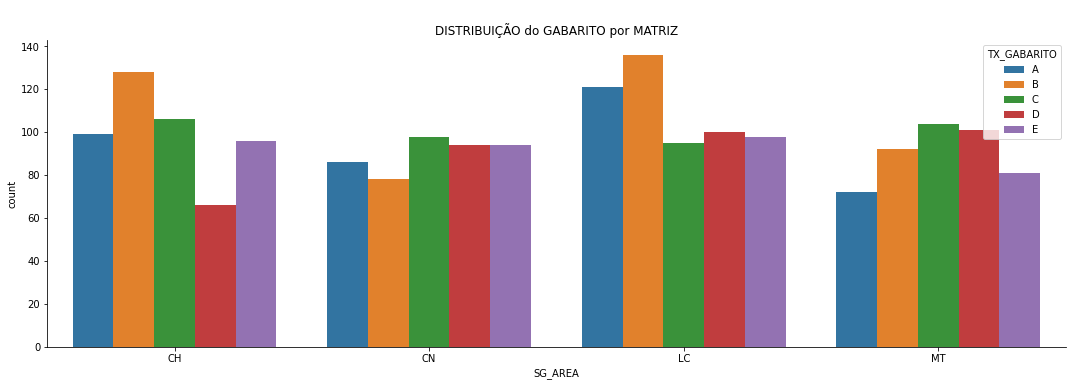

In [28]:
df3 = df.groupby(['TX_GABARITO', 'SG_AREA']).size().reset_index(name='count')
#
ax1 = sns.catplot(x='SG_AREA', y= 'count', hue='TX_GABARITO', data=df3, kind='bar', height=5, aspect=3,legend_out=False)
#sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, .9), ncol=4, title=None, frameon=True)
ax.fig.set_figwidth(17)
ax.fig.set_figheight(7.7)
# Show the plot
plt.title('\nDISTRIBUIÇÃO do GABARITO por MATRIZ')
plt.show()

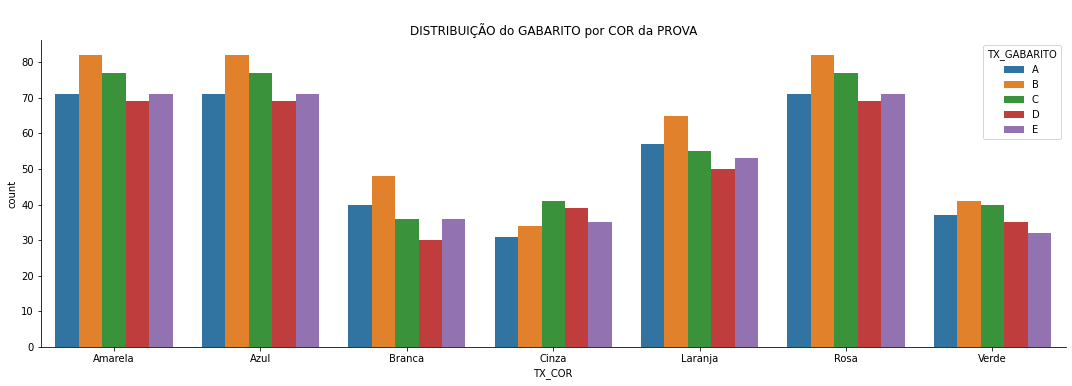

In [29]:
df4 = df.groupby(['TX_GABARITO', 'TX_COR']).size().reset_index(name='count')
#
ax1 = sns.catplot(x='TX_COR', y= 'count', hue='TX_GABARITO', data=df4, kind='bar', height=5, aspect=3,legend_out=False)
#sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, .9), ncol=4, title=None, frameon=True)
ax.fig.set_figwidth(17)
ax.fig.set_figheight(7.7)
# Show the plot
plt.title('\nDISTRIBUIÇÃO do GABARITO por COR da PROVA')
plt.show()

# Quantidade de provas por Cor no Enem.

In [30]:
df.TX_COR.value_counts()

Azul       370
Amarela    370
Rosa       370
Laranja    280
Branca     190
Verde      185
Cinza      180
Name: TX_COR, dtype: int64

## Distribuição da cor da prova pelas 4 areas

In [31]:
temp = df.groupby(['SG_AREA','TX_COR']).size().reset_index(name='count_area_cor_prova')
temp

,SG_AREA,TX_COR,count_area_cor_prova
0,CH,Amarela,90
1,CH,Azul,90
2,CH,Branca,90
3,CH,Laranja,90
4,CH,Rosa,90
5,CH,Verde,45
6,CN,Amarela,90
7,CN,Azul,90
8,CN,Cinza,90
9,CN,Laranja,45


## Número 4 e 2 representam a quantidade de areas onde a cor aparece.

In [32]:
temp.TX_COR.value_counts()

Amarela    4
Azul       4
Laranja    4
Rosa       4
Verde      4
Branca     2
Cinza      2
Name: TX_COR, dtype: int64

In [33]:
temp.loc[temp.TX_COR=='Azul']

,SG_AREA,TX_COR,count_area_cor_prova
1,CH,Azul,90
7,CN,Azul,90
13,LC,Azul,100
19,MT,Azul,90


In [34]:
temp2 = temp.loc[(temp.TX_COR=='Branca') | (temp.TX_COR=='Cinza')]

# Provas de cor Branca e Cinza estão presentes apenas em 2 areas.
- Branca : CH  /  LC
- Cinza  : CN /  MT 

In [35]:
temp2

,SG_AREA,TX_COR,count_area_cor_prova
2,CH,Branca,90
8,CN,Cinza,90
14,LC,Branca,100
20,MT,Cinza,90
